# Targeting specific user jobs
This script is designed to try and narrow down information on specific users jobs for anomaly detection

In [41]:
#get data to test on
#replace user and filter name
import epmt_query as eq
import time
import sys
sys.path.insert(0,'/home/Avery.Kiihne/pip_experiment')
import matplotlib.pyplot as plt
import numpy as np
user = 'Colleen.McHugh'
filter_name = 'SPEAR'
user_jobs = eq.get_jobs(fltr=(eq.Job.user_id == user), fmt = 'dict')



In [31]:
# sort jobs based on factor that is being looked for in experiment name
user_filtered = []
for job in user_jobs:
    exp_dir=job['env_dict']['SLURM_SUBMIT_DIR']
    if (filter_name in exp_dir) or (filter_name.lower() in exp_dir.lower()):
        user_filtered.append(job)



In [36]:
#call a general group of jobs and find SPEAR runs in them to compare
start = time.time()
job_num = 5*len(user_filtered)   #number of jobs grabbed
all_jobs = []
for aa in range(10):
    jobs_temp = eq.get_jobs(limit=job_num/10, before = -1, offset = job_num*aa/10, 
                           fmt='dict')
    all_jobs.extend(jobs_temp)
    print('at ',(aa+1)*10,'% completion. time elapsed:',(time.time()-start)/60)
#now filter those jobs as well.
all_jobs_filtered = []
for job in all_jobs:
    exp_dir=job['env_dict']['SLURM_SUBMIT_DIR']
    if (filter_name in exp_dir) or (filter_name.lower() in exp_dir.lower()):
        all_jobs_filtered.append(job)



at  10 % completion. time elapsed: 0.4295579195022583
at  20 % completion. time elapsed: 0.8555205941200257
at  30 % completion. time elapsed: 1.3359492421150208
at  40 % completion. time elapsed: 1.3478911519050598
at  50 % completion. time elapsed: 1.3611589352289835
at  60 % completion. time elapsed: 1.3728461027145387
at  70 % completion. time elapsed: 1.3835066119829813
at  80 % completion. time elapsed: 1.3941679437955221
at  90 % completion. time elapsed: 1.405169673760732
at  100 % completion. time elapsed: 1.4167774796485901


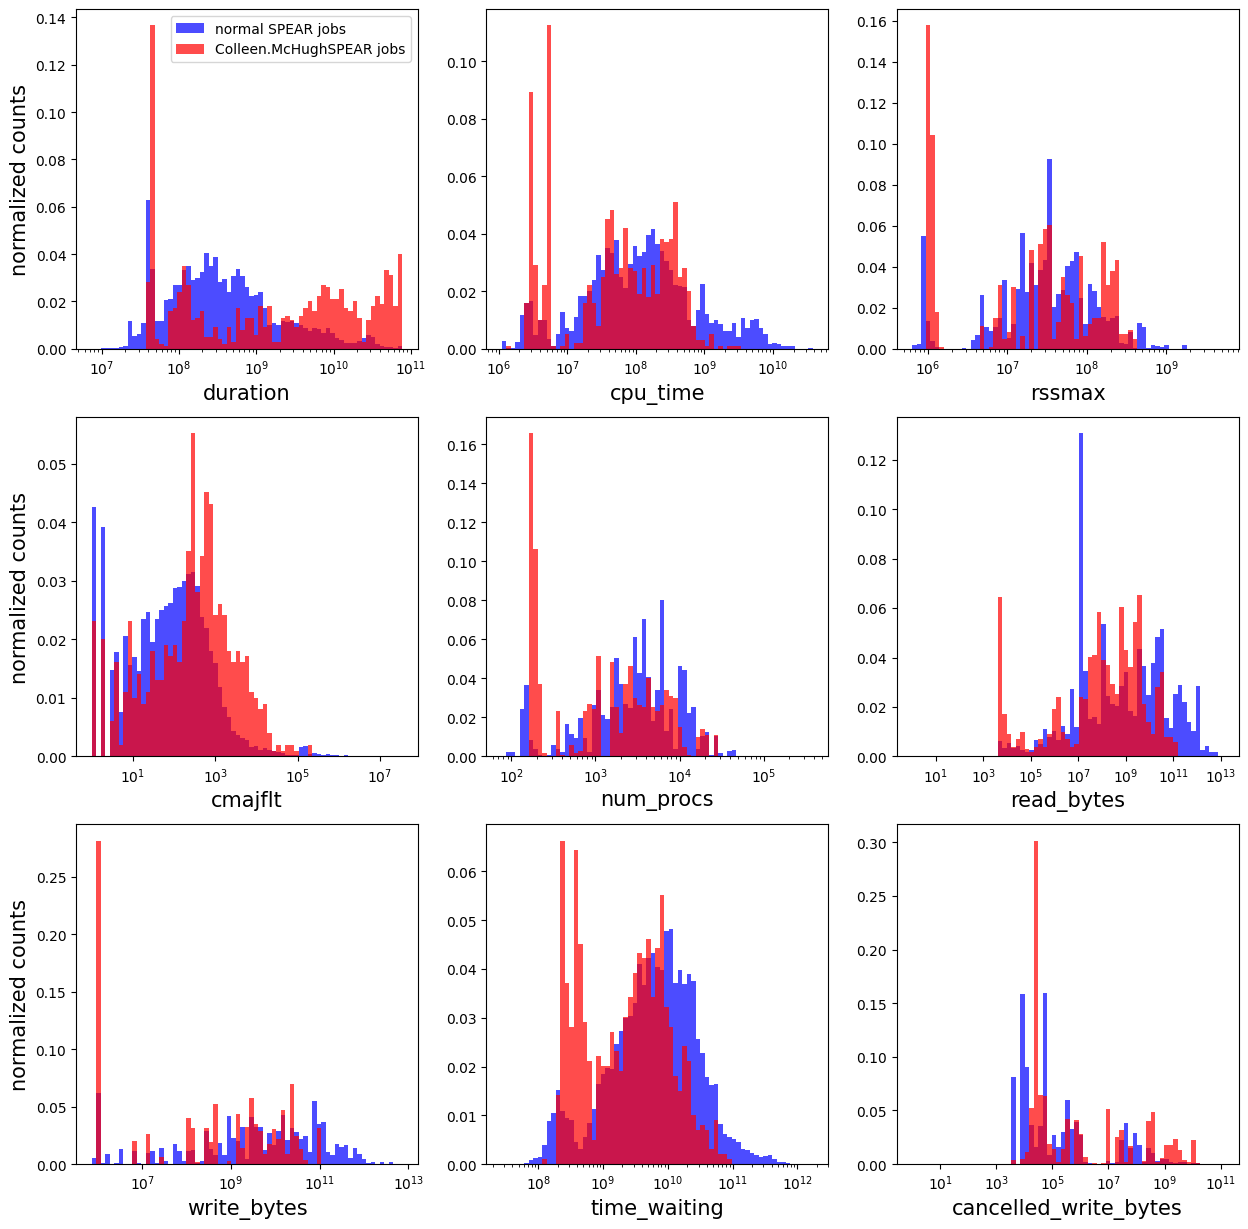

In [44]:
#subplot of every factor, with the spike data separated
#factor_list = [ 'duration', 'rchar', 'syscr', 'syscw', 'wchar', 'cstime', 'cutime', 'majflt', 'cpu_time', 'minflt', 'rssmax', 'cmajflt','cminflt', 'inblock', 'outblock', 'usertime', 'num_procs', 'starttime', 'vol_ctxsw', 'read_bytes', 'systemtime', 'time_oncpu', 'timeslices', 'invol_ctxsw', 'write_bytes', 'time_waiting', 'cancelled_write_bytes']
factor_list = [ 'duration', 'cpu_time', 'rssmax', 'cmajflt', 'num_procs',  'read_bytes',  'write_bytes', 'time_waiting',  'cancelled_write_bytes']
color = 'blue'
binning = {}
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
ax =ax.ravel() 
for jobs in [all_jobs_filtered,user_filtered]:
    if jobs == user_filtered:
        color = 'red'
    for ff in range(len(factor_list)):
        factor = factor_list[ff]
        data_list = []
        for job_instance in range(len(jobs)):
            if jobs[job_instance].get(factor) != None:   #prevents breakage if set is empty or doesn't exist
                data_list.append(jobs[job_instance][factor])
        
        #make plot
        plt.style.use('default')

        bins = 70
        #bin check for zero, as it messes up np.log10()
        if min(data_list) == 0:
            bottom_bin = 0
        else:
            bottom_bin = np.log10(min(data_list))
        #make binning shared for spike and not spike
        if jobs == all_jobs_filtered:
            binning[factor] = np.logspace(bottom_bin,np.log10(max(data_list)),bins)
        #set scaling factor
        ax[ff].hist(data_list, bins = binning[factor], color = color,density = False, weights = np.ones(len(data_list))/len(data_list),alpha = .7)
        ax[ff].set_xlabel(factor, fontsize = 15)
        ax[ff].set_xscale('log')
ax[0].set_ylabel('normalized counts', fontsize = 15)
ax[3].set_ylabel('normalized counts', fontsize = 15)
ax[6].set_ylabel('normalized counts', fontsize = 15)
ax[0].legend(['normal '+filter_name+' jobs',user+filter_name+' jobs'])
plt.savefig('analysis_plots/super_hist_spike.pdf', bbox_inches='tight', format = 'pdf')

# Specific job lifespans
look at a small sample of users jobs using procs to see if progress shows any issues

In [59]:
#use orm format to get jobs and then feed to get_procs for a quicker run time
#need few jobs because each will be lasered in on
start = time.time()
job_num = 9
user_sample_jobs = eq.get_jobs(user_filtered[-10:-1], fmt='orm') #format for passing to get_procs
procs_user_sample = eq.get_procs(jobs = user_sample_jobs, fmt='dict')
print(f'number of elements in procs_all={len(procs_user_sample)}')
print("time:",(time.time()-start)/60)

number of elements in procs_all=8228
time: 0.040197102228800456


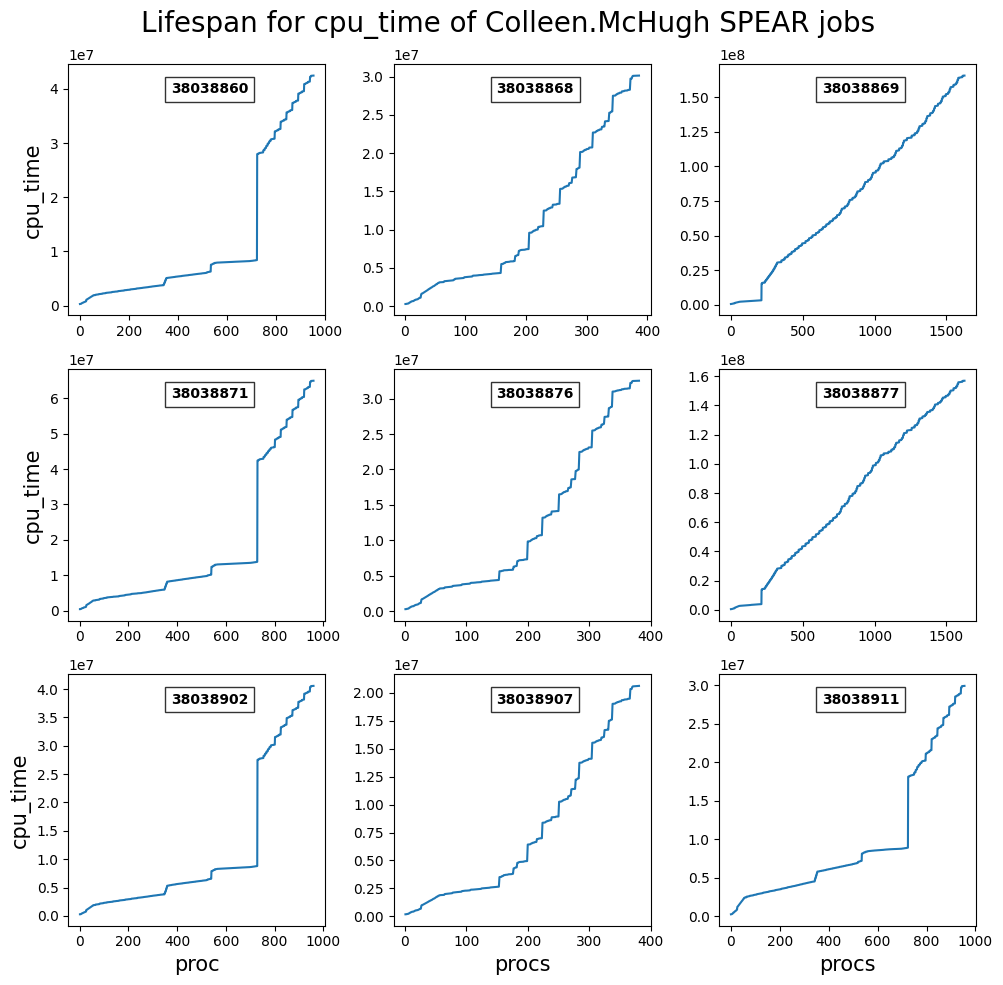

In [65]:
#make 3x3 grid of progressional plots for a variable
#variable_list = ['rssmax', 'cminflt',  'write_bytes',  'cancelled_write_bytes', 'minflt','rchar','time_waiting','cmajflt','cpu_time']
variable = 'cpu_time'
plt.style.use('default')
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,10))
ax =ax.ravel() 
for job_instance in range(9):
    procs_of_job = eq.get_procs(jobs = user_sample_jobs[job_instance], fmt='dict')
    total = 0
    progress = []
    proc_step = np.linspace(1,len(procs_of_job),len(procs_of_job))
    for proc_instance in range(len(procs_of_job)):
        total += procs_of_job[proc_instance][variable]
        progress.append(total)
    ax[job_instance].plot(proc_step,progress)
    ax[job_instance].annotate(procs_of_job[proc_instance]['jobid'], xy=(0.4, 0.9), xycoords="axes fraction",color = 'black', fontsize =10, weight = 'bold',horizontalalignment='left',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Lifespan for '+variable+' of '+user +' '+filter_name+' jobs',  fontsize = 20)
ax[0].set_ylabel(variable, fontsize = 15)
ax[3].set_ylabel(variable, fontsize = 15)
ax[6].set_ylabel(variable, fontsize = 15)
ax[6].set_xlabel('proc',fontsize = 15)
ax[7].set_xlabel('procs',fontsize = 15)
ax[8].set_xlabel('procs',fontsize = 15)
plt.tight_layout()

9